In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
from PIL import Image, ImageDraw
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2




In [13]:
# Define paths to the directories containing the train and test datasets
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'

train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [14]:
# TRAINING DATA SUMMARY
print("PRINTING LABELS INFO")
print(train_df.info())
print("PRINTING FIRST 5 ROWS OF THE TRAINING DATA SET")
print(train_df.head())

PRINTING LABELS INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
PRINTING FIRST 5 ROWS OF THE TRAINING DATA SET
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [15]:
print("PRITNTING SUMMARY OF THE TRAINING DATASET")
print(train_df.describe())

PRITNTING SUMMARY OF THE TRAINING DATASET
               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000


We can see that for a binary classification, the .describe() is not of great usage to us. 

label
0    130908
1     89117
Name: count, dtype: int64


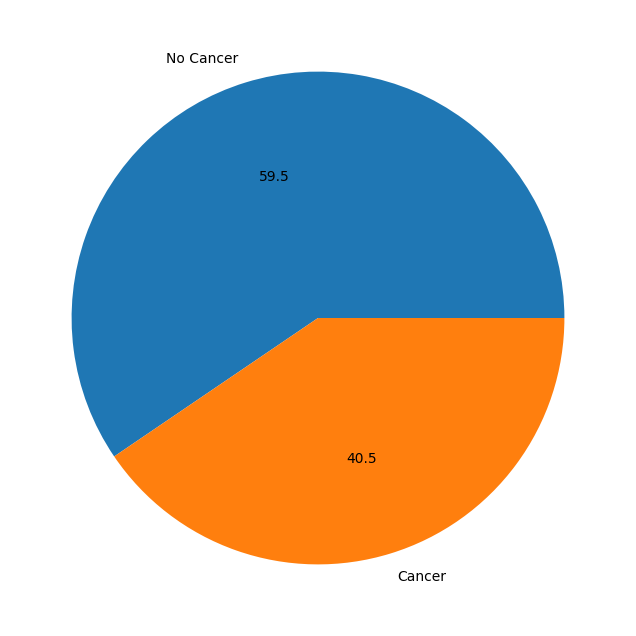

In [16]:
#Let's look at the value counts. 

label_count = train_df.label.value_counts()
print(label_count)

plt.figure(figsize = (10,8))
plt.pie(label_count, labels=['No Cancer', 'Cancer'], autopct='%1.1f')
plt.show()

normal ids
['f38a6374c348f90b587e046aac6079959adf3835'
 '755db6279dae599ebb4d39a9123cce439965282d'
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08'] 

malignant ids
['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f']


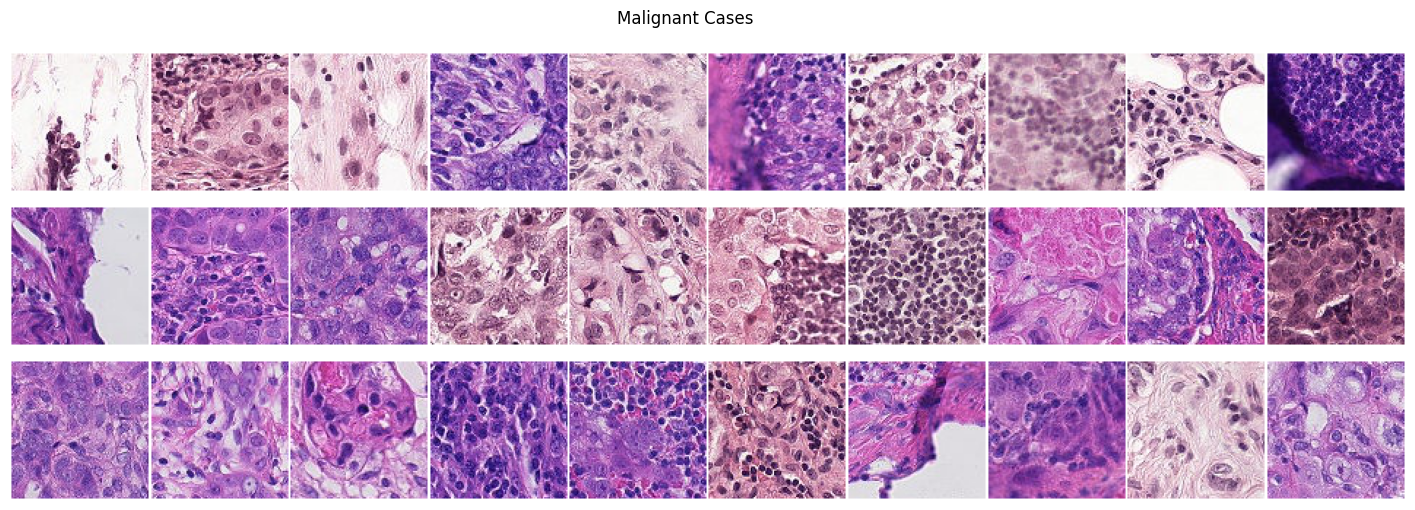

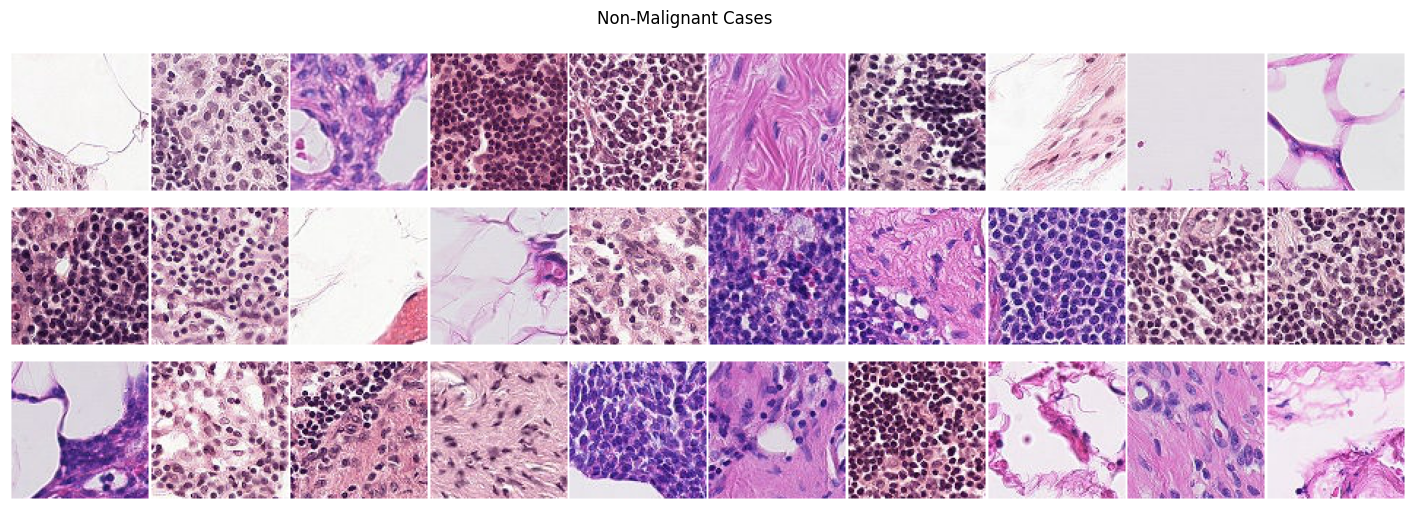

In [17]:
imgpath ="/kaggle/input/histopathologic-cancer-detection/train/" # training data is stored in this folder
malignant = train_df.loc[train_df['label']==1]['id'].values    # get the ids of malignant cases
normal = train_df.loc[train_df['label']==0]['id'].values       # get the ids of the normal cases

print('normal ids')
print(normal[0:3],'\n')

print('malignant ids')
print(malignant[0:3])
import os 

def plot_fig(ids,title,nrows=3,ncols=10):

    fig,ax = plt.subplots(nrows,ncols,figsize=(18,6))
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(imgpath ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

plot_fig(malignant,'Malignant Cases')
plot_fig(normal,'Non-Malignant Cases')

**Sampling of the DATA SET**

In [18]:
# Here since we 225025 images in our datasets, and out of which 89117 images are indicated - 0, and 130908 images are indicated as 1,
#let s split our data set into 140000 samples and train on them to make predictions later. The 140000 samples will be split equally between 0 and 1. 


df_normal = train_df[train_df['label'] == 0].sample(70000, random_state = 42)
df_malignant = train_df[train_df['label'] == 1].sample(70000, random_state = 42)

# Concatenating the two sampled datasets.
df_comb_train = pd.concat([df_normal, df_malignant])

# Shuffling the combined dataset.
df_comb_train = df_comb_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the combined dataset
print(df_comb_train.head())  # This shows the first few rows of the concatenated and shuffled dataset.

                                         id  label
0  6b29496376ef520c8d0b42aaeccc402a87928ca6      0
1  e5ea41aecaf92e421d08292fe1ee495031daa64e      0
2  02c6c9c9a671d83ff050b8844bb929aac33556ae      1
3  cc89bf695bd22c7276338e0e7efd602a2f11a62c      1
4  dda02d4042f244cb732421152be17d2d61ebb086      0


PRINTING LABELS INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140000 entries, 0 to 139999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      140000 non-null  object
 1   label   140000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ MB
None
PRINTING FIRST 5 ROWS OF THE TRAINING DATA SET
                                         id  label
0  6b29496376ef520c8d0b42aaeccc402a87928ca6      0
1  e5ea41aecaf92e421d08292fe1ee495031daa64e      0
2  02c6c9c9a671d83ff050b8844bb929aac33556ae      1
3  cc89bf695bd22c7276338e0e7efd602a2f11a62c      1
4  dda02d4042f244cb732421152be17d2d61ebb086      0
label
0    70000
1    70000
Name: count, dtype: int64


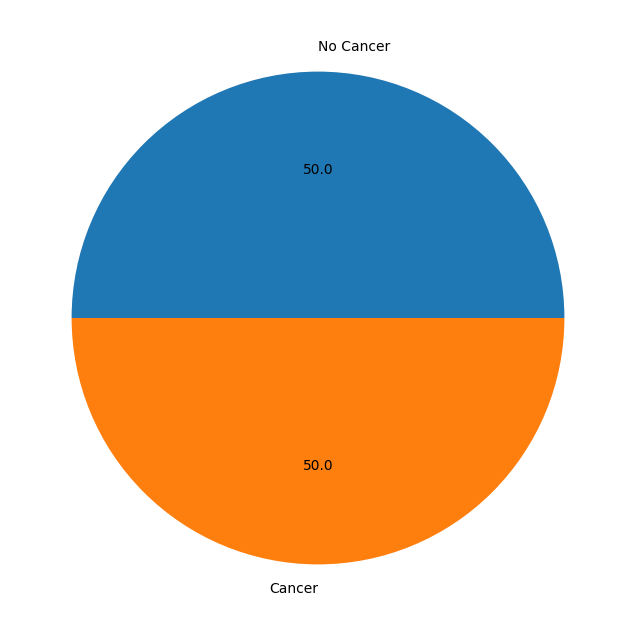

In [19]:
# TRAINING DATA SUMMARY
print("PRINTING LABELS INFO")
print(df_comb_train.info())
print("PRINTING FIRST 5 ROWS OF THE TRAINING DATA SET")
print(df_comb_train.head())

#Let's look at the value counts. 

labels_counts = df_comb_train.label.value_counts()
print(labels_counts)

plt.figure(figsize = (10,8))
plt.pie(labels_counts, labels=['No Cancer', 'Cancer'], autopct='%1.1f')
plt.show()

In [20]:
# Rescale pixel values, split for validation, and prepare ImageDataGenerators
batch_size = 64
target_size = (60, 60)

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize image pixel values
    validation_split=0.25  # Reserve a portion for validation
)


# Update 'id' column to match file names and convert 'label' to string for generator
df_comb_train['id'] = df_comb_train['id'].apply(lambda x: x + '.tif')
df_comb_train['label'] = df_comb_train['label'].astype(str)


# Initialize generators for train and validation datasets using df_comb_train
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_comb_train,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)


validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df_comb_train,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)



Found 105000 validated image filenames belonging to 2 classes.
Found 35000 validated image filenames belonging to 2 classes.


In [21]:
# Define the CNN architecture using Input object
model = Sequential([
    Input(shape=(60, 60, 3)),  # Define the input shape here
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display a summary of the model
model.summary()

# Callbacks for early stopping and reducing learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 912,961 (3.48 MB)

 Trainable params: 912,961 (3.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1640/1640 ━━━━━━━━━━━━━━━━━━━━ 1118s 678ms/step - accuracy: 0.7437 - loss: 0.5180 - val_accuracy: 0.8098 - val_loss: 0.4301 - learning_rate: 0.0010
Epoch 2/10
   1/1640 ━━━━━━━━━━━━━━━━━━━━ 4:29 164ms/step - accuracy: 0.7188 - loss: 0.5355

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1640/1640 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - accuracy: 0.7188 - loss: 0.5355 - val_accuracy: 0.7679 - val_loss: 0.4915 - learning_rate: 0.0010
Epoch 3/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 417s 254ms/step - accuracy: 0.8129 - loss: 0.4153 - val_accuracy: 0.8246 - val_loss: 0.4006 - learning_rate: 0.0010
Epoch 4/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 0s 37us/step - accuracy: 0.7500 - loss: 0.4623 - val_accuracy: 0.8036 - val_loss: 0.4633 - learning_rate: 0.0010
Epoch 5/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 398s 242ms/step - accuracy: 0.8416 - loss: 0.3636 - val_accuracy: 0.8541 - val_loss: 0.3360 - learning_rate: 0.0010
Epoch 6/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 0s 37us/step - accuracy: 0.8438 - loss: 0.3345 - val_accuracy: 0.8036 - val_loss: 0.3792 - learning_rate: 0.0010
Epoch 7/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 393s 239ms/step - accuracy: 0.8563 - loss: 0.3370 - val_accuracy: 0.8434 - val_loss: 0.3579 - learning_rate: 0.0010
Epoch 8/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 0s 42us/step - accuracy: 0.89

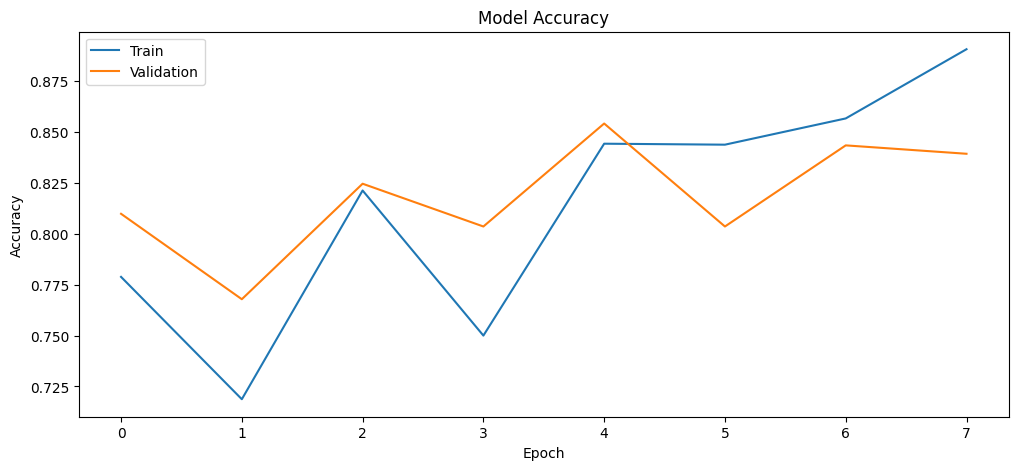

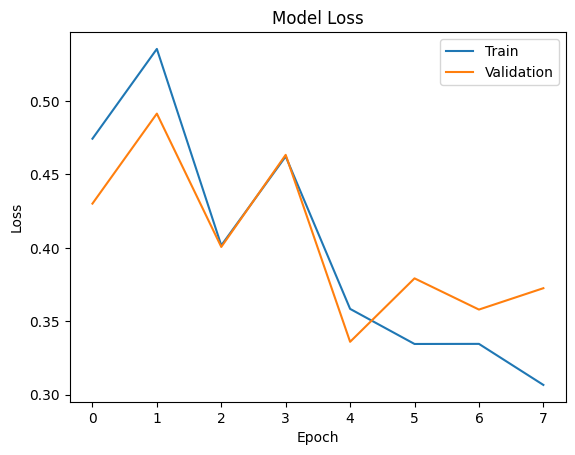

In [22]:


# Function to plot training history
import matplotlib.pyplot as plt
def plot_history(history, metric):
    """
    Plot model training history.
    Args:
    - history: Training history returned by model.fit()
    - metric: Metric to be plotted (e.g., 'accuracy', 'loss')
    """
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.title('Model ' + metric.title())
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

# Displaying results
plt.figure(figsize=(12, 5))
plot_history(history, 'accuracy')
plot_history(history, 'loss')



In [23]:
# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'id': os.listdir(test_dir)}),
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=target_size,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

# Predict on test data
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples)

# Prepare the submission DataFrame
filenames = test_generator.filenames
ids = [filename.split('.')[0] for filename in filenames]
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

submission_df = pd.DataFrame({
    'id': ids,
    'label': predicted_labels
})

# Save submission.csv
submission_df.to_csv('submission.csv', index=False)

print("submission.csv file has been created successfully!")

Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 408s 7ms/step
submission.csv file has been created successfully!
